**루브릭 1. 이미지 분류기 모델이 성공적으로 만들어졌는가?**  
학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음

-> 학습을 정상적으로 수행했고, 시각화 또한 수행했습니다.

**루브릭 2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?**  
오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음

-> 실험은 예비실험(`data_300`)과 본실험(`data_2100`)의 두 단계로 나누었습니다.
예비실험에서는 300장의 그림파일 (`data_300` : 가위 100장, 바위 100장, 보 100장)을 임의로 섞은 뒤 250장을 train set으로 50장을 test set으로 삼아 모델을 학습하고 평가했습니다. <font color = 'red'> (2.2. 예비실험) </font>
그 결과, 성능이 올바르게 나오지 않았습니다.
epoch 3에서 64%의 accuracy를 보이며 제대로 학습하는 듯 했으나, 이내 accuracy가 떨어지더니 20%정도의 안좋은 성능을 보였습니다.
아무리 epoch 수를 늘린다고 하더라도 train loss가 계속 줄어드는 반면, test loss는 감소하지 않고, test accruacy 또한 증가하지 않았습니다.
따라서 overfitting이 일어나는 것으로 판단했습니다.
overfitting의 원인으로 생각한 것은, 데이터의 개수가 적다는 점이었습니다.

본 실험에서는 데이터를 2100개로 늘렸습니다.
이 데이터 (`data_2100` : 가위 700장, 바위 700장, 보 700장)에 대한 자세한 사항은 <font color = 'red'> (3.1. 데이터 할당하기) </font>에 자세히 적어놓았습니다.
1800장을 train set으로 300장을 test set으로 삼아 모델을 학습하고 평가했습니다. <font color = 'red'> (3.2. 본실험(1)) </font>
그 결과 성능이 상당히 향상되어 70% 정도의 성능을 보였습니다.

이어서, 정규화까지도 진행하여 성능이 더 좋아지는 지를 판단했습니다.
데이터의 각 값들을 0과 1 사이의 값들로 (선형) 변환하여  일정한 값들을 가지도록 했습니다.
하지만, 유의미한 성능의 향상이 있지는 않았고, 거의 같은 성능을 내는 것을 확인했습니다. <font color = 'red'> (3.3. 본실험(2)) </font>

**루브릭 3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?**  
60% 이상 도달하였음

-> <font color = 'red'> (3.2. 본실험(2)) </font>에 보면 70%에 가까운 test accuracy를 확인할 수 있습니다.


*jupyter notebook extension의 table of contents(2) 기능을 활용하여 보시면, 장과 절을 더 확실히 볼 수 있어 편합니다. (ex. 3.1. 데이터 할당하기)*

*주요 결과는 <font color = 'red'>(4.2, 주요 결과 요약) </font>, <font color = 'red'>(4.3. 결론)</font>에 적었습니다.*

# 사전 작업

## 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from PIL import Image
import glob

In [2]:
print(tf.__version__)
print(np.__version__)

2.8.0
1.20.3


## helper function 정의하기

In [3]:
def resize_images(img_path, size=28):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(size,size)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [4]:
def load_data(img_path, number_of_data = 300,size = 28):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*size*size*color,dtype=np.int32).reshape(number_of_data,size,size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


## 데이터 만들기

파일트리

Github

├── aiffel_explorations

    ├── 05.ipynb

    └── .git

└── data

    └── exploration_05

        ├── data_300

            ├── scissors

            ├── rock

            └── paper

        ├── data_2100

            ├── train

                ├── scissors

                ├── rock

                └── paper

            ├── test

                ├── scissors

                ├── rock

                └── paper

        ├── data_300.zip

        ├── data_300_preparation.gif

        ├── data_2100.zip
        
        ├── change_filenames.ipynb

        └── readme.text

[teachable machine](https://teachablemachine.withgoogle.com/) 에서 두 종류(`data_300`, `data_2100`)의 데이터를 만들었다.
[이 링크](https://drive.google.com/drive/folders/1U5KqWVkhkoZj9NxzPqvAHdTcPf-JCwa_?usp=sharing)는 위의 파일트리에서 `data` 폴더이다.

### `data_300`

9월 30일 오전 6시 경, 아이펠에 출근하기 전에 집에서 내 손을 찍었다.
바위 100장, 가위 100장, 보 100장의 사진을 찍었다.
이 사진들을, 위의 트리에서 `GitHub/data/exploration_05/data_300` 안에 있는 세 폴더 `rock`, `scissors`, `paper`에 각각 넣어놓았다.
그리고 `data_300` 폴더는 통째로 압축하여 `data_300.zip` 파일로 `GitHub/data/exploration_05` 안에 저장해놓았다.
이것은 원본 사진파일을 저장해놓기 위함이다.

### `data_2100`

`data_300`으로는 충분한 실험을 하지 못할 것이라고 판단하고, 다시 사진을 찍었다.
이 과정에서 많은 수고와 노력이 들었다.

일정한 조명과 단색 배경이 있는 방에서 일곱 명의 사진을 일정한 기준에 맞춰 찍었다.

[teachable machine](https://teachablemachine.withgoogle.com/)에서는 디폴트로 FPS 24의 연속촬영을 지원한다.
이 설정으로 찍을 경우, 3-5개의 사진이 1/24초의 간격으로 찍히는 것 같다.
그런데 이렇게 하면, 거의 비슷한 사진들 이 3-5개씩 있게 된다.
그러면, 데이터로서는 좋지 않을 것 같았다.

FPS 24 옵션을 해제하고, 직접 클릭으로 수동으로 간격을 늦춰서 찍었다.
촬영간격은 약 0.1초 - 0.5초 정도였던 것 같다.
촬영을 계속하는 동안, 손을 조금씩 움직여서 다양한 종류의 사진이 나오도록 했다.
각도와 위치를 계속해서 옮겨가면서, 같은 주먹 (혹은 가위, 보) 이지만 조금씩 다른 사진을 찍도록 했다.

예컨대, 주먹 100개를 찍을 때에는, 왼쪽 자리에서 왼손으로 30개, 왼쪽 자리에서 오른손으로 30개, 오른쪽 자리에서 왼손으로 30개, 오른쪽 자리에서 오른손으로 30개를 찍어서 120장의 사진을 만든 다음, 그중에서 잘 찍히지 않은 20장 정도를 제외하여 100개를 맞췄다.
보도 마찬가지로 했는데, 가위는 조금 다르게 했다.
가위의 경우 엄지와 검지를 사용해 가위를 표현할 수도 있고, 검지와 중지를 사용해 가위를 표현할 수 도 있으므로, 가짓수가 두 배 더 많다.
각각의 경우에 15장씩을 찍어서 120장의 사진을 만든 다음, 그 중에 100장을 추렸다.

사진 촬영에 참가한 사람은, 날 포함해서 총 7명으로, 그 중 6명은 남자였고, 1명은 여자였다.
각 사람당 300장의 사진, 즉 가위 100장과 바위 100장, 보 100장을 찍었으므로 총 2100장의 사진이 얻어졌다.
이것들은 위의 파일트리에서 `GitHub/data/exploration_05/data_2100` 안에 있는 세 폴더 `rock`, `scissors`, `paper`에 각각 넣어놓았다.

각각의 폴더에는 0부터 699까지의 숫자로 파일명이 저장되어 있는데, 그 중 0부터 99번까지는 내 손을 찍은 사진이다.
200번부터 299번까지는 소매가 조금 나오기도 한 남자분의 사진이고, 500번부터 599번까지는 여자분의 손이다.
(누가 어떤 데이터에 대응되는 지에 대해서는`readme.txt`에 적어놓았다.)
그 중 가장, 개인적으로 공들여서 찍었다고 여겨지는 내 사진 (0~99)을 test set으로 삼았고, 나머지 사진들은 train set으로 삼았다.

파일명을 숫자로 저장하는 데 있어서도 신경을 잘 써야 했다.
이를 위해서, 다음과 같이 생긴 파이썬 코드(`change_filenames.ipynb`)를 사용하였다.
```
dir_path = "C:/Users/govin/Downloads/rock-samples" # 작업할 대상 파일 위치
res = glob.glob(dir_path+"/*")

os.makedirs("C:/Users/govin/Downloads/rock-samples_modified", exist_ok=True) # 저장할 파일 위치
for i, f in enumerate(res,n): # 출력 : n00 ~ n99
    im1 = Image.open(f)
    im1.save("C:/Users/govin/Downloads/rock-samples_modified//" + str(i) + ".jpg") # 저장할 파일 위치 + \\
```

## 모델 정의하기

모델은 LMS 노드에 정의한 모델을 그대로 쓴다.
여기에 정의해놓고 두고두고 불러와서 사용하겠다.

In [5]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (No

In [6]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 예비실험 : 300개 데이터

## 데이터 할당하기

In [7]:
resize_images("../data/exploration_05/data_300/scissors")
resize_images("../data/exploration_05/data_300/rock")
resize_images("../data/exploration_05/data_300/paper")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


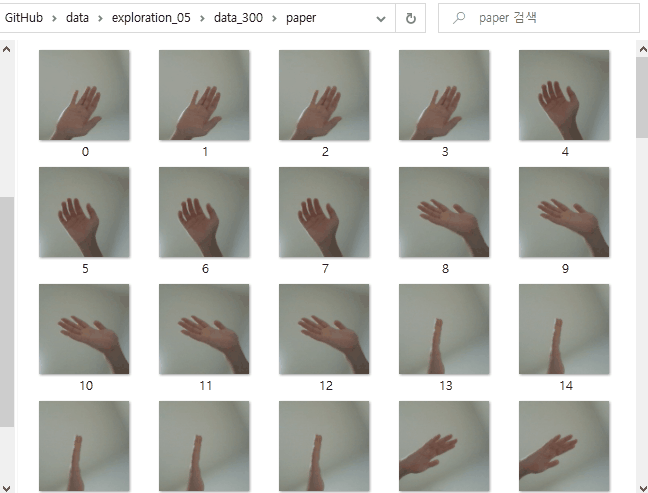

In [8]:
X, y = load_data("../data/exploration_05/data_300")

학습데이터(x_train)의 이미지 개수는 300 입니다.


In [9]:
arr = np.arange(300)
np.random.shuffle(arr)
X = X[arr]

[0 0 1 2 0 0]


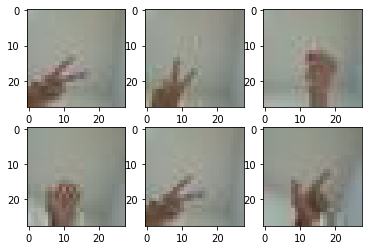

In [10]:
plt.subplot(231)
plt.imshow(X[0])
plt.subplot(232)
plt.imshow(X[1])
plt.subplot(233)
plt.imshow(X[2])
plt.subplot(234)
plt.imshow(X[3])
plt.subplot(235)
plt.imshow(X[4])
plt.subplot(236)
plt.imshow(X[5])
print(y[arr][:6])

In [11]:
X_train = X[:250]
X_test  = X[250:]
y_train = y[:250]
y_test  = y[250:]

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(250, 28, 28, 3)
(50, 28, 28, 3)
(250,)
(50,)


## 예비실험

In [13]:
hist = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 500)

Epoch 1/500
8/8 [==============================] - 1s 36ms/step - loss: 17.1581 - accuracy: 0.3640 - val_loss: 5.8485 - val_accuracy: 0.0400
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 5.4223 - accuracy: 0.3320 - val_loss: 1.4381 - val_accuracy: 0.5800
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 3.1796 - accuracy: 0.3280 - val_loss: 2.8002 - val_accuracy: 0.1600
Epoch 4/500
8/8 [==============================] - 0s 12ms/step - loss: 2.1642 - accuracy: 0.4040 - val_loss: 4.6166 - val_accuracy: 0.0200
Epoch 5/500
8/8 [==============================] - 0s 13ms/step - loss: 2.1957 - accuracy: 0.4080 - val_loss: 5.0457 - val_accuracy: 0.0200
Epoch 6/500
8/8 [==============================] - 0s 14ms/step - loss: 1.8778 - accuracy: 0.4480 - val_loss: 3.2717 - val_accuracy: 0.0800
Epoch 7/500
8/8 [==============================] - 0s 12ms/step - loss: 1.6824 - accuracy: 0.4240 - val_loss: 2.4480 - val_accuracy: 0.1800
Epoch 8/500
8/8 [==

8/8 [==============================] - 0s 12ms/step - loss: 0.5603 - accuracy: 0.7680 - val_loss: 2.9823 - val_accuracy: 0.2400
Epoch 118/500
8/8 [==============================] - 0s 13ms/step - loss: 0.4977 - accuracy: 0.7880 - val_loss: 4.3261 - val_accuracy: 0.0400
Epoch 119/500
8/8 [==============================] - 0s 12ms/step - loss: 0.5033 - accuracy: 0.7840 - val_loss: 3.0470 - val_accuracy: 0.2400
Epoch 120/500
8/8 [==============================] - 0s 12ms/step - loss: 0.5163 - accuracy: 0.7960 - val_loss: 2.6364 - val_accuracy: 0.3200
Epoch 121/500
8/8 [==============================] - 0s 11ms/step - loss: 0.4740 - accuracy: 0.8000 - val_loss: 3.4814 - val_accuracy: 0.1400
Epoch 122/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5033 - accuracy: 0.7840 - val_loss: 3.0391 - val_accuracy: 0.2200
Epoch 123/500
8/8 [==============================] - 0s 11ms/step - loss: 0.4695 - accuracy: 0.8280 - val_loss: 3.2963 - val_accuracy: 0.2400
Epoch 124/500
8/8 [=

Epoch 175/500
8/8 [==============================] - 0s 12ms/step - loss: 0.3512 - accuracy: 0.8880 - val_loss: 3.6260 - val_accuracy: 0.2200
Epoch 176/500
8/8 [==============================] - 0s 12ms/step - loss: 0.3423 - accuracy: 0.9000 - val_loss: 4.2551 - val_accuracy: 0.1800
Epoch 177/500
8/8 [==============================] - 0s 11ms/step - loss: 0.3142 - accuracy: 0.9280 - val_loss: 4.3922 - val_accuracy: 0.2000
Epoch 178/500
8/8 [==============================] - 0s 12ms/step - loss: 0.3364 - accuracy: 0.8920 - val_loss: 3.7585 - val_accuracy: 0.2800
Epoch 179/500
8/8 [==============================] - 0s 11ms/step - loss: 0.3570 - accuracy: 0.8720 - val_loss: 4.5169 - val_accuracy: 0.2000
Epoch 180/500
8/8 [==============================] - 0s 11ms/step - loss: 0.3204 - accuracy: 0.9000 - val_loss: 4.1807 - val_accuracy: 0.2400
Epoch 181/500
8/8 [==============================] - 0s 12ms/step - loss: 0.3107 - accuracy: 0.9000 - val_loss: 4.8111 - val_accuracy: 0.1400
Epoch 

Epoch 233/500
8/8 [==============================] - 0s 12ms/step - loss: 0.2194 - accuracy: 0.9440 - val_loss: 4.7410 - val_accuracy: 0.2600
Epoch 234/500
8/8 [==============================] - 0s 11ms/step - loss: 0.2425 - accuracy: 0.9240 - val_loss: 5.7055 - val_accuracy: 0.1400
Epoch 235/500
8/8 [==============================] - 0s 11ms/step - loss: 0.2369 - accuracy: 0.9240 - val_loss: 5.2438 - val_accuracy: 0.2400
Epoch 236/500
8/8 [==============================] - 0s 11ms/step - loss: 0.1953 - accuracy: 0.9440 - val_loss: 5.5434 - val_accuracy: 0.1800
Epoch 237/500
8/8 [==============================] - 0s 12ms/step - loss: 0.1850 - accuracy: 0.9640 - val_loss: 5.0631 - val_accuracy: 0.2400
Epoch 238/500
8/8 [==============================] - 0s 11ms/step - loss: 0.1852 - accuracy: 0.9560 - val_loss: 5.8668 - val_accuracy: 0.1600
Epoch 239/500
8/8 [==============================] - 0s 11ms/step - loss: 0.1945 - accuracy: 0.9560 - val_loss: 5.7689 - val_accuracy: 0.1800
Epoch 

Epoch 291/500
8/8 [==============================] - 0s 11ms/step - loss: 0.1117 - accuracy: 0.9760 - val_loss: 6.2947 - val_accuracy: 0.2200
Epoch 292/500
8/8 [==============================] - 0s 11ms/step - loss: 0.1035 - accuracy: 0.9840 - val_loss: 6.1967 - val_accuracy: 0.2400
Epoch 293/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0967 - accuracy: 0.9920 - val_loss: 6.9336 - val_accuracy: 0.1800
Epoch 294/500
8/8 [==============================] - 0s 12ms/step - loss: 0.1016 - accuracy: 0.9840 - val_loss: 6.0619 - val_accuracy: 0.2800
Epoch 295/500
8/8 [==============================] - 0s 11ms/step - loss: 0.1037 - accuracy: 0.9760 - val_loss: 6.6339 - val_accuracy: 0.1800
Epoch 296/500
8/8 [==============================] - 0s 11ms/step - loss: 0.1189 - accuracy: 0.9680 - val_loss: 6.2278 - val_accuracy: 0.2000
Epoch 297/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0969 - accuracy: 0.9760 - val_loss: 6.3665 - val_accuracy: 0.2400
Epoch 

Epoch 349/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0658 - accuracy: 0.9880 - val_loss: 7.2162 - val_accuracy: 0.2600
Epoch 350/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0628 - accuracy: 0.9800 - val_loss: 7.0494 - val_accuracy: 0.2400
Epoch 351/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0555 - accuracy: 0.9960 - val_loss: 7.5322 - val_accuracy: 0.2200
Epoch 352/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0631 - accuracy: 0.9840 - val_loss: 7.4531 - val_accuracy: 0.2200
Epoch 353/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0723 - accuracy: 0.9800 - val_loss: 8.0633 - val_accuracy: 0.1600
Epoch 354/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0811 - accuracy: 0.9800 - val_loss: 7.8069 - val_accuracy: 0.2400
Epoch 355/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0758 - accuracy: 0.9840 - val_loss: 6.2085 - val_accuracy: 0.2800
Epoch 

Epoch 407/500
8/8 [==============================] - 0s 11ms/step - loss: 1.2066 - accuracy: 0.6920 - val_loss: 5.0671 - val_accuracy: 0.2800
Epoch 408/500
8/8 [==============================] - 0s 11ms/step - loss: 1.2793 - accuracy: 0.6560 - val_loss: 3.7087 - val_accuracy: 0.2800
Epoch 409/500
8/8 [==============================] - 0s 12ms/step - loss: 1.1341 - accuracy: 0.5760 - val_loss: 3.7998 - val_accuracy: 0.1600
Epoch 410/500
8/8 [==============================] - 0s 13ms/step - loss: 0.9883 - accuracy: 0.5400 - val_loss: 3.1016 - val_accuracy: 0.1400
Epoch 411/500
8/8 [==============================] - 0s 15ms/step - loss: 0.9277 - accuracy: 0.5720 - val_loss: 1.6431 - val_accuracy: 0.2600
Epoch 412/500
8/8 [==============================] - 0s 16ms/step - loss: 0.8225 - accuracy: 0.6120 - val_loss: 2.5710 - val_accuracy: 0.2200
Epoch 413/500
8/8 [==============================] - 0s 13ms/step - loss: 0.7622 - accuracy: 0.6080 - val_loss: 2.3324 - val_accuracy: 0.2200
Epoch 

Epoch 465/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0752 - accuracy: 0.9720 - val_loss: 7.8746 - val_accuracy: 0.2400
Epoch 466/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0532 - accuracy: 0.9920 - val_loss: 9.2425 - val_accuracy: 0.1600
Epoch 467/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0397 - accuracy: 0.9960 - val_loss: 9.3763 - val_accuracy: 0.2000
Epoch 468/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0418 - accuracy: 1.0000 - val_loss: 10.4290 - val_accuracy: 0.1800
Epoch 469/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0349 - accuracy: 0.9960 - val_loss: 9.2313 - val_accuracy: 0.2600
Epoch 470/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0293 - accuracy: 0.9960 - val_loss: 9.8442 - val_accuracy: 0.1800
Epoch 471/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 9.5600 - val_accuracy: 0.2000
Epoch

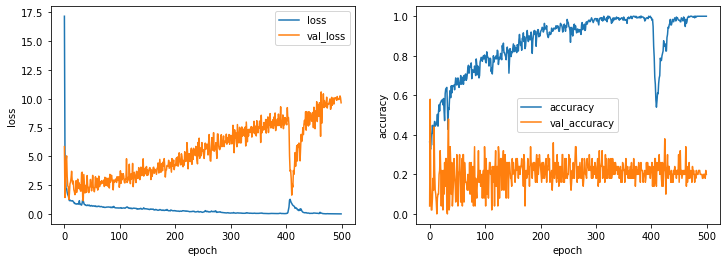

In [14]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

In [15]:
result1 = model.evaluate(X_test,y_test)
result1

2/2 [==============================] - 0s 4ms/step - loss: 9.6519 - accuracy: 0.2000


[9.651883125305176, 0.20000000298023224]

# 본실험 : 2100개 데이터

## 데이터 할당하기

In [16]:
resize_images("../data/exploration_05/data_2100/train/scissors")
resize_images("../data/exploration_05/data_2100/train/rock")
resize_images("../data/exploration_05/data_2100/train/paper")
resize_images("../data/exploration_05/data_2100/test/scissors")
resize_images("../data/exploration_05/data_2100/test/rock")
resize_images("../data/exploration_05/data_2100/test/paper")

600  images to be resized.
600  images resized.
600  images to be resized.
600  images resized.
600  images to be resized.
600  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


위의 세 개의 `resize_image(...)`를 선언하여, 원본 이미지를 resize하여 저장해놓는다.

In [17]:
X_train, y_train = load_data("../data/exploration_05/data_2100/train", number_of_data = 1800)
X_test, y_test = load_data("../data/exploration_05/data_2100/test", number_of_data = 300)

학습데이터(x_train)의 이미지 개수는 1800 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.


In [18]:
arr = np.arange(1800)
np.random.shuffle(arr)
X_train = X_train[arr]
y_train = y_train[arr]
arr = np.arange(300)
np.random.shuffle(arr)
X_test = X_test[arr]
y_test = y_test[arr]

[2 2 2 2 0 0]


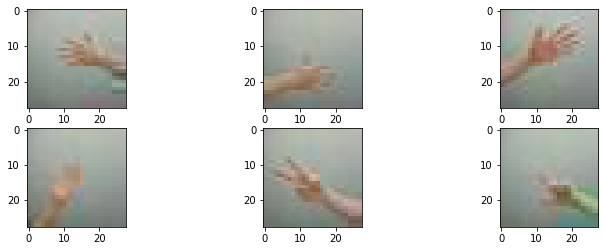

In [19]:
plt.subplot(231)
plt.imshow(X_train[0])
plt.subplot(232)
plt.imshow(X_train[1])
plt.subplot(233)
plt.imshow(X_train[2])
plt.subplot(234)
plt.imshow(X_train[3])
plt.subplot(235)
plt.imshow(X_train[4])
plt.subplot(236)
plt.imshow(X_train[5])
print(y_train[:6])

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800, 28, 28, 3)
(300, 28, 28, 3)
(1800,)
(300,)


## 본실험(1) : 정규화 하지 않음.

In [21]:
hist = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)

Epoch 1/50
57/57 [==============================] - 1s 10ms/step - loss: 1.3102 - accuracy: 0.3594 - val_loss: 1.0593 - val_accuracy: 0.3900
Epoch 2/50
57/57 [==============================] - 1s 10ms/step - loss: 1.0739 - accuracy: 0.3800 - val_loss: 1.0602 - val_accuracy: 0.4000
Epoch 3/50
57/57 [==============================] - 1s 10ms/step - loss: 1.0863 - accuracy: 0.3817 - val_loss: 1.0387 - val_accuracy: 0.4067
Epoch 4/50
57/57 [==============================] - 1s 9ms/step - loss: 1.0530 - accuracy: 0.4344 - val_loss: 1.0019 - val_accuracy: 0.4900
Epoch 5/50
57/57 [==============================] - 1s 9ms/step - loss: 1.0330 - accuracy: 0.4456 - val_loss: 1.0228 - val_accuracy: 0.4067
Epoch 6/50
57/57 [==============================] - 0s 9ms/step - loss: 0.9963 - accuracy: 0.4794 - val_loss: 1.0222 - val_accuracy: 0.4000
Epoch 7/50
57/57 [==============================] - 1s 9ms/step - loss: 0.9774 - accuracy: 0.5011 - val_loss: 0.8679 - val_accuracy: 0.6000
Epoch 8/50
57/57 

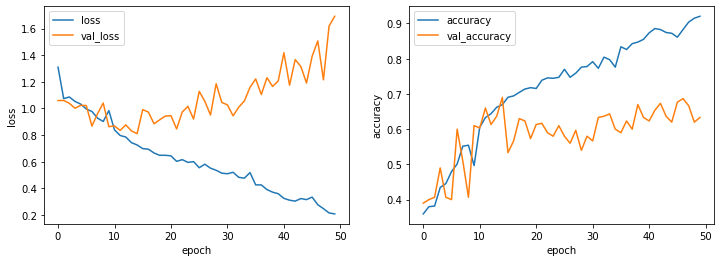

In [22]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

In [23]:
result2 = model.evaluate(X_test,y_test)
result2

10/10 [==============================] - 0s 4ms/step - loss: 1.6924 - accuracy: 0.6333


[1.6923582553863525, 0.6333333253860474]

## 본실험(2) : 정규화를 수행함.

In [24]:
X_train = X_train/255.0
X_test  = X_test/255.0

In [25]:
hist = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)

Epoch 1/50
57/57 [==============================] - 1s 11ms/step - loss: 1.1558 - accuracy: 0.3456 - val_loss: 1.0931 - val_accuracy: 0.4633
Epoch 2/50
57/57 [==============================] - 1s 9ms/step - loss: 1.0899 - accuracy: 0.3989 - val_loss: 1.0825 - val_accuracy: 0.4133
Epoch 3/50
57/57 [==============================] - 1s 10ms/step - loss: 1.0843 - accuracy: 0.4161 - val_loss: 1.0739 - val_accuracy: 0.5400
Epoch 4/50
57/57 [==============================] - 1s 9ms/step - loss: 1.0757 - accuracy: 0.4556 - val_loss: 1.0697 - val_accuracy: 0.3733
Epoch 5/50
57/57 [==============================] - 1s 9ms/step - loss: 1.0691 - accuracy: 0.4600 - val_loss: 1.0459 - val_accuracy: 0.5967
Epoch 6/50
57/57 [==============================] - 1s 9ms/step - loss: 1.0559 - accuracy: 0.4883 - val_loss: 1.0209 - val_accuracy: 0.6000
Epoch 7/50
57/57 [==============================] - 1s 9ms/step - loss: 1.0363 - accuracy: 0.5061 - val_loss: 0.9964 - val_accuracy: 0.4900
Epoch 8/50
57/57 [

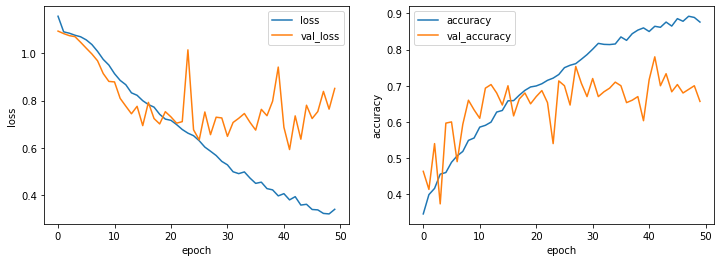

In [26]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

In [27]:
result3 = model.evaluate(X_test,y_test)
result3

10/10 [==============================] - 0s 4ms/step - loss: 0.8511 - accuracy: 0.6567


[0.8511354327201843, 0.6566666960716248]

# 회고 및 결론

## 회고

[작성일자 : 10월 3일 월요일]

1. 회고  
지난 exploration에 이어 두번째 회고를 쓴다.
사실, 완전히 끝내지는 못한 상태라고 생각한다.
루브릭 조건은 다 만족시키긴 했는데, 아직 더 할 수 있는 실험들은 많다.
너무 많다.
그럼에도 불구하고, 다른 할 일이 있으니, 지금 이 상태로 제출한 뒤 나중에 수정할 수 있으려면 하겠다.

2. 지난 주 금요일 (9월 30일 금요일)  
지난 9월 30일 금요일, 나는 왠지 필사적으로 이 exploration 노드를 하려고 했다.
이번 연휴동안에는 논문을 반드시 마무리지어야겠다는 생각으로, 금요일 당일에 이 exploration node를 마무리 지으려고 했다.
보통 이런 경우에는, 노드가 열리는 자정부터 exploration을 붙잡고 열심히 매달리기도 했다.
새벽까지 공부해놓고 출근하거나, 밤을 새서 공부하거나 코딩해놓고 출근하는 것이다.
하지만 이 날은 그렇게까지 하지는 않았다.
다만 눈이 일찍 떠져서 5시에 일어났고, 아침 댓바람부터 누워서 이 노드를 펴고 보기 시작하기는 했다.
CNN의 기본 문제이고, 익숙한 loss-val\_loss 그래프를 그리면 되겠다, 다만 데이터를 만들어야 하구나, 하는 생각 정도를 가지고 아침 7시쯤 노트북을 닫았다.
노트북으로 내 손 사진을 찍기도 했다.
이때 직은 사진이 `data_300`에 해당하는 사진들이다.
아침 8시에 집을 나서면서는 되려 여유로운 마음까지 들었다.
그날따라 특히, 그 주에는 운동을 하루도 하지 않았다는 사실을 상기하고, 출근을 자전거로 하기로 했다.
1시간여를 달려서, 성수대교를 건너고 강남의 두 언덕을 지나 8시 40분쯤 모두의 연구소에 도착했다.  
아침부터 한 일은, 손 사진 찍을 사람을 모집한 일이었다.
우리 조의 여섯 명을 모아 사진을 찍기로 한 후, 옆 방에 가서 사진관(?)을 차렸다.
일정한 조명에서, 단색의 배경을 두고 내 노트북으로 손사진을 찍기 시작했다.
내 손을 가장 먼저 찍고, 다음에는 한용님의 사진을 찍었다.
사진 파일 이름의 파일명을 일괄적으로 변경하는 것과 관련해서는 한용님께서 도와주셨다.
그리고 나니 점심시간이 되었다.
연수님께서도 따로 사진을 찍어서 내게 보내주셨다.
연수님의 사진은 우리와는 다른 배경과 다른 조건에서 찍힌거라, 포함해도 될까 싶었지만, 일단 포함시켰다.
나중에 성능이 안나오면 그때 다시 사진을 요청하거나 그 사진들만 빼면 된다는 생각이었다.
점심은 연수님께서 사주셨다.
(너무 얻어먹어서, 다음에는 한 번 내가 쏴야지, 하는 생각을 하다가도, 지갑 사정을 보니 그렇게 하기는 좀 힘들겠다는 생각도 들었다.)  
오후가 되어, 다른 분들의 사진도 찍기 시작했다.
성하님, 희성님, 예진님 (그리고, 4층에서 내려오신 종태님) 순으로 찍었다.
예진님의 경우, 여자분이다보니, 데이터에 넣어도 될까 싶은 생각을 했지만, 연수님의 케이스와 마찬가지로, 일단 넣어놓고, 나중에 성능이 안나오면 그때 생각하자는 쪽으로 결정했다.  
사진을 찍을 때에 한가지 이슈는, 예컨대 보를 내미는 포즈를 찍을 때, 손바닥이 일직선인 모습이 찍히면 (이것을 나는 왠지 '당수唐手'라고 불렀다.) 그것을 보의 사진으로서 인정해야 하느냐 하는 것이었다.
일단은 대부분의 의견에 따라, 그리고 내 주관에 따라 그러한 사진은 배제하는 쪽으로 가닥을 잡았지만, 성하님의 의견은 달랐다.
최대한 다양한 종류의 사진을 넣어야 한다는 말씀이었다.
지금 생각해보면, 당수 사진을 배제했어도 되고, 배제하지 않았어도 되었을 것 같다.
어차피 700개의 사진을 찍고, 거기에서 train set과 test set을 나눠서 할 것이기 때문에, 당수 사진이 있도록 데이터를 모았으면 있는대로 문제가 없을 것이고, 없도록 모았으면 그것대로 문제가 없었을 것이다.
다만, 당수사진이 있는지, 없는지의 여부가 데이터셋 전체에 동일하게 적용되어야 할 것이다.
가령 train set에는 당수 사진을 포함시키지 않았는데 test set에는 당수 사진을 포함시켰으면, 우리의 classifier는 당수 사진을 뭘로 결정할 지 알 수 없었을 것이다.  
열심히 작업하여, 오후 3-4시 경에는 데이터를 모으는 작업이 완료되었던 것 같다.
생각해보면, 300개에서 2100개로 늘어난 것이 아주 많은 양으로 늘은 것은 아니라고 생각되기도 한다.
점심때, 다른 분들과 같이 밥을 먹었던 자리에서, 나는 "딥러닝이 머신러닝과 다른 점 중 하나가, 딥러닝은 머신러닝에 비해 훨씬 더 많은 데이터를 사용해야 한다. 그런데 오늘 노드인 CNN은 딥러닝에 해당한다고 볼 수 있으므로, 데이터가 많아야 할 것이다."라고 아는 체 했다.
그런데, 내가 정확한 의미를 파악하고 그런 말을 한 것은 아니었다.
많으면 얼마나 많아야 하는지 그런 것은 알지 못하고 그냥 한 말이었다.  
여하튼, 작업이 끝나자마자, 나는 손 사진 촬영에 응해준 여섯 분에게 데이터를 뿌렸다.
그리곤, 퇴근하는 6시가 될 때까지 나는 힘이 들어서 라운지에 나와서 좀 쉬거나, 다른 사람들이 모델을 짜는 것을 보거나, 아니면 다른 분들에게 오버피팅이나, `model.fit`의 `history`에 대해 이야기하거나 했다.
실제로, 이후에 모델을 구성하고 실험하는 것은 그렇게 어려운 작업이 아니었지만 집중이 잘되지 않았다.
가장 먼저 목표 정확도에 도달하는 모델을 구성한 분은, (이번에도) 종태님이었다.
종태님 코드가 다른 분들 코드와 달랐던 점은, `skleran`의 `train_test_split` 메서드를 사용한 점, 한 명 분의 데이터만을 test set으로 잡고 나머지는 train set으로 삼았다는 점 등이다.
나는 별 소득 없이 있다가 퇴근했다.

3. 오늘 (10월 3일 월요일)  
내가 이 exploration 노드를 열심히 하려고 했던 이유는, 이것을 빨리 끝내고 논문작업을 하려는 목적이었지만, 정작 연휴동안 논문에는 손도 거의 대지 못했다.
다른 해야 하는 일들이 있었기도 했고, 특히 오늘은 이 exploration 노드를 얼추 마무리해야 했기 때문이다.
오늘의 작업 내용까지만 정리하여, 일단 제출하려 한다.  
구성은 다음과 같이 했다. "1. 사전작업"에서는 모듈을 불러오는 코드와 helper function을 정의하는 코드, 데이터의 정리 내용과 모델을 정의하는 코드를 넣었다.
그 중 데이터에 관해 정리한 내용에는 상당한 시간을 들여서 썼다.
지금 이 파일(05.ipynb)파일과 데이터 파일들이 어떤 (상대적인) 위치에 저장되어 있는지를 파일 트리를 이용해 표현했고, 데이터를 모은 방식에 대해서도 꽤 적어놓았다.
하지만 아주 상세하게 적어놓은 것은 아니었고, 또한 같은 내용이 이 문서의 맨 처음과, 그리고 이 부분(회고)에 중복되어 표현되어 있을 수 있다.
모델을 정의하는 코드 또한 위로 빼서 1장에 적었다.
나중에 실험할 때에, 공간을 잡아먹는 것이 싫어서 그렇게 했다.
사실 가장 좋게는, 실험을 수행하는 함수를 만들어놓고 그 코드만 실행해서 돌리는 것일 것이다.
하지만 이번 실험은 그렇게까지 복잡한 실험인 것도 아니기도 하고 해서, 그냥 2장과 3장을 나누는 것 정도로만 만족했다.  
"2. 예비실험"에서는 금요일 아침에 찍어놓은 나의 300개짜리 사진을 가지고 수행한 예비실험을 넣었다.
여기에서는 300개의 사진을 준비한 후 이것을 임의로 섞은 후 250개를 train set으로, 50개를 test set으로 두어 실험했다.
train set - test set 을 나누고 실험하는 데에는 아무런, 논리적인 잘못이 없다고 여겨진다.
하지만 당연히, 데이터 수가 너무 적기 때문에, 이 실험은 실패하는 것이 예견되어 있었다.
마치, p-value를 공부할 때 배웠던 귀무가설처럼, 너무 데이터가 적으면 안된다는 것을 말하기 위한 일종의 교두보였던 셈이다.
그래도 굳이 결과를 적자면, epoch 3쯤에서 validation accuracy가 높게 나오므로, 이때쯤 최적의 학습이 일어났으며, 그 이후로는 overfitting이 일어났다고 볼 수 있다.
사실 이 말도 좀 애매한데, 그러니까 굳이 말하자면 그렇다는 것이다.
하지만, 다시 실험했을 때는 epoch 3에서 validation accuracy가 높게 나오는 현상은 발생하지 않았다.
그냥, 정상적인 학습이 잘 일어나지 않는, 애매한 상태라고 보여진다.
일부러 epoch 수를 500쯤으로 두었는데, 이것은 `val_accuracy` 그래프가 감소하거나 횡보하더라도, 나중에는 학습이 반영되어 상승할 수 있을 가능성을 염두에 두고 한 것이다.
하지만 `val_accuracy`는 끝내 상승하지 않았으며, `val_loss`는 증가하기만 했다.
그러니까, 그냥 overfitting이 일어났다고밖에 판단할 수 없겠다.  
"2. 본실험"에서는 2100개의 사진으로 이루어진 `data_2100` 데이터를 가지고 실험한 결과를 적었다.
맨 처음 사진들 (내 사진들) 300개를 test set으로 삼았고, 나머지는 train set으로 삼았다.
필요한 일일 지는 모르겠지만 (그러니까, 추가적인 실험의 여지가 있지만) train set과 test set으로 나눈 이미지들을 내부적으로 한 번 더 섞어서 `X_train`, `y_train`과 `X_test`, `y_test`를 만들었다.
물론 섞을 때에는 `X_train`과 `y_train`의 sample 순서가 맞아떨어지도록 조심해서 섞었다.
결과는 만족스럽게 (accuracy 80%) 나오다가도, 다시 실험하면 그정도의 성능까지는 나오지 않는 (accuracy 60%) 등의 상황들이 있었다.
정규화를 하지 않은 경우와 정규화를 한 경우를 나눠서 실험하기도 했는데, 가끔은 둘 사이에 그렇게 큰 accuracy 차이가 나지 않다가도, 또 어떤 때는 정규화를 할 때에 성능이 더 좋게 나왔다.

[추가작성일자 : 10월 4일 화요일]

4, 추가회고  
생각해보면, accuracy를 더 높일 수 있는 방안은 당연히 존재한다.
데이터를 만들 때에, 조금 더 비슷한, 그러니까 더 균일한 데이터들만 썼으면 됐을 것이다.
MNIST dataset를 생각해보면, MNIST dataset은 70000개의 data를 가지고 있다.
2100개를 가지고 있는 우리의 데이터 `data_2100`은, MNIST dataset에 비해서는 상당히 적기는 하지만, 비견되지 못할 정도는 아니다.
`data_2100`이 MNIST 데이터에 비해 다른 점은, 데이터들이 class별로 일정한 모양새를 띄지 않는다는 점이다.
MNIST 데이터는 일정한 크기로, 꽤 명확하게 0부터 9까지의 숫자들이 적혀있다.
하지만 `data_2100`은 그렇지 않다.
가위만 해도 엄지+검지의 가위가 있고 검지+중지의 가위가 있다.
보와 주먹 또한 보이는 각도와 보이는 위치에 따라서 천차만별의 모양새를 띄고 있다.
방향과 각도보다 더 큰 영향을 미치는 것은 '카메라까지의 거리'(손의 크기)일 듯하다.
많은 사진의 경우 손만 찍힌 것이 아니라 손에 연결된 팔까지도 찍혔다.
나는, accuracy가 기대했던 것 만큼 나오지 않자, 이 사진들을 조금 수정하여 정말 균일한 기준을 가지는 dataset으로 만들려고도 해봤다.
그러니까, 손이 상대적으로 작게 나오고 팔까지 포함된 사진들에 대해서는 손 부분만 crop해보려고도 했다.
어차피 28x28 resulution으로 다시 resize할 것이니 만약, 그 작업을 했다면 accuracy가 비약적으로 높아졌을 수도 있겠다.  
MNIST dataset처럼 일정한 모양을 가지는 데이터면서 70000개 정도가 나와야 MLP나 CNN 정도 수준에서도 높은 accuracy를 보이는 것이라고 추측된다.
손 사진의 경우, 당연히 숫자보다는 더 복잡한 이미지이고, 아까 언급했던 다양한 종류의 변형(모양, 각도, 위치, 크기)이 존재한다.
따라서, 손사진으로 좋은 성능을 내려면 70000개를 넘어서는 숫자의 데이터들이 있어야만 한다. 예컨대 기십만개, 아니 기백만개가 있어야 할 것 같다.
(그리고, 일반적으로 딥러닝을 하려면 수천개만의 데이터로는 유의미한 결과를 낼 수 없다고도 들었던 것 같다.)
하지만, 우리의 데이터는 2100개이고, 따라서 아주 획기적인 수준의 (e.g. 80%, 90% 이상) accuracy는 내지 못하는 것이라고 생각된다.

## 주요 결과 요약

오늘의 결과는, 코드 전체를 몇 번 돌려서 주요한 지표들을 나열하는 것으로 요약하는 것이 가장 바람직하겠다.
세 번의 실험
- 2.2. 예비실험
- 3.2. 본실험 (1) : 정규화하지 않음.
- 3.3. 본실험 (2) : 정규화를 수행함.  

의 결과(`val_loss`, `val_accuracy`)를 각각 `result1`, `result2`, `result3`라는 변수로 저장하고, 그것을 다시 `row0`이라는 `np.array`에 저장한 뒤 `flatten`하여, 그 결과를 메모장에 잘 적어놓는다.
`row0`에는 여섯 가지 지표가 담길 것이다.
그리고 다시 전체 코드를 돌려(restart \& run all) `result1`, `result2`, `result3`를 `row1`로 저장한 뒤 `flatten`하여 그 결과를 메모장에 적어놓는다.
이렇게 다섯 번 전체 코드를 돌려 `row4`까지의 결과를 얻은 뒤, 메모장에 적은 내용들을 토대로 `pd.DataFrame`으로 정리하면 깔끔할 것이다.

In [28]:
#row0 = np.array([result1, result2, result3]).flatten()
#row1 = np.array([result1, result2, result3]).flatten()
#row2 = np.array([result1, result2, result3]).flatten()
#row3 = np.array([result1, result2, result3]).flatten()
#row4 = np.array([result1, result2, result3]).flatten()
#row4

array([9.65188313, 0.2       , 1.69235826, 0.63333333, 0.85113543,
       0.6566667 ])

In [31]:
row0 = np.array([8.31214809, 0.14      , 1.20459926, 0.66000003, 0.56121469, 0.78666669])
row1 = np.array([9.65188313, 0.2       , 1.69235826, 0.63333333, 0.85113543, 0.6566667 ])
row2 = np.array([10.15078735,  0.2       ,  1.16369534,  0.66333336,  0.86829722, 0.73333335])
row3 = np.array([7.49950743, 0.28      , 1.48355925, 0.68666667, 0.96668017, 0.68000001])
row4 = np.array([6.93285513, 0.23999999, 2.00665903, 0.69666666, 0.71872485, 0.72000003])

In [32]:
df = pd.DataFrame([row0, row1, row2, row3, row4])
df.columns = ['예비실험, loss', '예비실험, val-acc','본실험(1), loss', '본실험(1), val-acc','본실험(1), loss', '본실험(2), val-acc']
df

,"예비실험, loss","예비실험, val-acc","본실험(1), loss","본실험(1), val-acc","본실험(1), loss","본실험(2), val-acc"
0,8.312148,0.14,1.204599,0.660000,0.561215,0.786667
1,9.651883,0.20,1.692358,0.633333,0.851135,0.656667
2,10.150787,0.20,1.163695,0.663333,0.868297,0.733333
3,7.499507,0.28,1.483559,0.686667,0.966680,0.680000
4,6.932855,0.24,2.006659,0.696667,0.718725,0.720000


언급했듯, 정규화를 한 것과 하지 않은 것이 차이가 크게 없는 경우도 있었다. (row 3)
심지어 이 경우에는, 정규화를 수행할 경우의 accuracy가 더 낮았다.
하지만 대부분의 경우에는 정규화를 수행할 경우, 수행하지 않은 경우에 비해 accuracy가 높다는 것을 알 수 있다.  
사실, 여기에서 말하는 정규화에 대하여, 나는 상당히 많은 시간에 걸쳐서 고민한 바가 있다.
딥러닝을 처음 접할 때 으레 마주하게 되는 MNIST 데이터셋에서, 거의 모든 코드들이 각 픽셀의 값($\in\{0,1,2,\cdots,255\}$)을 0과 1사이의 값으로 정규화한다.
여기에서 '정규화'라는 용어는 적절한 단어선택이라고 볼 수 있다.
z-score로 바꾸는 standardization을 표준화라고 해석한다면, minmax-scaling을 하는 normalization을 '정규화'라고 번역할 수 있는 것이다.
그러니까, 주어진 이미지에 minmax를 적용하는 것, 그것을 거의 모든 MNIST 데이터셋 분석에서 하고 있었다.
나는 이것에 대해, 적어도 2년 전부터 의문을 품어왔다. 저게 도대체 무슨 역할을 하는 것인지 궁금했다.
단순히 0과 1 사이의 값으로 rescaling한 것, 선형변환한 것뿐인데, 내가 본 모든 MNIST 코드에서는 이러한 minmax scaling을 하고 있었다.  
사실 아이펠에 들어와서도 저런 minmax scaling을 봤다.
「밑바닥부터 시작하는 딥러닝(Deep Learning from scratch, 사이토 고키)」3.6.2절 (100페이지)에서
```
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, flatten = True, one_hot_label = False)
```
라는 코드가 있었다.
그때도 의문을 품고 주변 분들에게 이러한 사항을 질문했지만, 대답해주실 분들이 없었다.
그런데, 이번 exploration 노드를 통해, 정규화를 하는 것이 효과가 있음을 결과적으로 확인한 셈이다.
이것은 나로서는 처음 경험하는 일이다.
그러니까, 정규화(normalization)의 효과를 처음 경험한 것이다.  
내가 이 문제에 대하여 의문을 품었을 때에, 한용님은 "프로그래밍적으로 빠른 계산을 위해서 하는 일이지 않을까"하는 의견을 말씀하셨고, 나는 그것을 맞다고 여겼다.
같은 책의 3.5.2에서 softmax 함수의 더 나은 계산속도를 위해서 softmax 함수를 조금 변형해서 계산하는 트릭이 있다는 부분이 있었다.
한용님은, 이와 같은 계산의 맥락에서 정규화를 하는 것이 아닐까, 하는 의견을 말씀하셨고, 나 또한 계산량이 줄어드는 부분이 있으리라고 생각하여 어느 정도 심정적으로 동의했던 것이다.
한용님이 지적하신 포인트도 일리가 있지만, 이것은 학습이 더 용이하게 만들어준다는 관점에서 해석하는 것이 더 맞지 않을까 싶기도 하다.  
정규화(standardization, z-score)와 표준화(normalization, minmax)의 목적이 무엇인가?
교수님 자료에는 feature간의 scale을 맞춰서 optimzation을 도와준다고만 되어있다.
이번 exploration node에서는 정규화가 overfitting을 방지하는 데 도움을 준다고 말하고 있다.
무엇이 옳은 지는 잘 모르겠다.
교수님의 자료에서 말하듯 feature 간의 scale을 맞춰서 optimization을 돕는 것은 당연하다.
정말 옳은 말이다.
그렇지만, 이번 본실험(1)에서, (정규화를 하지 않았다고 하더라도) optimization은 끝까지 진행된 것으로 보인다.
게다가, 이번 실험들에서는 feature 간의 scale이 잘 맞는 상태였으므로, 굳이 이것을 0과 1 사이로 rescale하는 것은 전혀 의미가 없다.  
하지만 어쨌든 정규화를 한 결과가 더 괜찮은 것으로 보아서는, 정규화가 단순히 optimization을 돕는 역할을 넘어선 다른 역할을 한다고 볼 수 있을 것 같다.
그것을 LMS node에서는 overfitting 방지의 역할이라고 본 것이다.  
유명한 블로그인 [Jason Brownlee의 블로그](https://machinelearningmastery.com/)에서도 rescale 이상의 무언가를 설명하지는 않고 있다.
[이 글](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/)에서 보면 교수님의 자료에서처럼 feature들 사이의 scale을 맞춰준다는 의미에서만 설명하고 있다.

## 결론

이번 exploration node를 통해 다음과 같은 사실들을 얻었다.
 - [teachable machine](https://teachablemachine.withgoogle.com/)에서 일정한 형식의 사진들을 직접 찍어서 이미지 데이터를 확보할 수 있었다.
 - `pillow`, `glob` 등을 통해 찍은 사진들을 resize 할 수 있었다.
 - 기본적인 CNN acrchitecture를 통해 이미지 분류 작업을 할 수 있었다.
 - 300장의 (28, 28) 사진만을 가지고는 의미있는 가위바위보 분류기를 만들 수 없었다.
 `val_accuracy`, `val_loss` 그래프를 통해서 볼 때, overfitting이 발생하리라고 추측할 수 있었다.
 - 데이터 수를 늘려 2100장의 (28, 28) 사진을 사용했더니, 60% 이상의 성능을 내는 가위바위보 분류기를 만들어낼 수 있었다.
 이 경우에도 overfitting은 발생하는 것으로 보이나, `val_accuracy`가 심각하게 떨어지는 정도는 아니었다.
 - 이전의 실험에서 정규화를 추가적으로 수행했더니, 다섯 번의 실험 중 네 번의 실험에서 `val_accuracy`가 증가했다.
 또한 `val_loss` 그래프가 증가하지 않고 횡보만 하는 것으로 보아 overfitting의 문제가 상당히 해결되었음을 알 수 있었다.
 - 다시 말해, **데이터를 더 늘리는 것과 정규화를 수행하는 두 가지 방법을 통해 overfitting의 문제를 해결할 수 있었다.**